<a href="https://colab.research.google.com/github/IT-17005/Schizophrenia/blob/main/EfficientNet_Schizo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
from google.colab import drive
drive .mount('/content/drive/') 

Mounted at /content/drive/


In [3]:
labels = ['non-scz','scz']

In [4]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/SchiFinalDataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/SchiFinalDataset','val',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 320/320 [00:02<00:00, 113.68it/s]


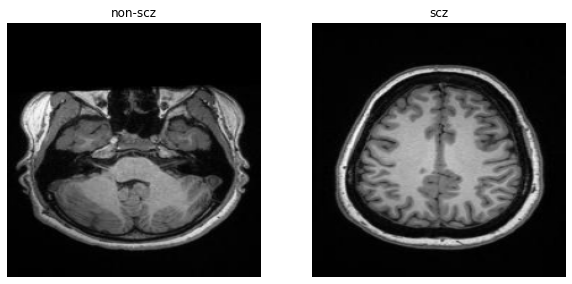

In [5]:
k=0
fig, ax = plt.subplots(1,2,figsize=(10,10))
fig.text(s='',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.6,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape

(3240, 224, 224, 3)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


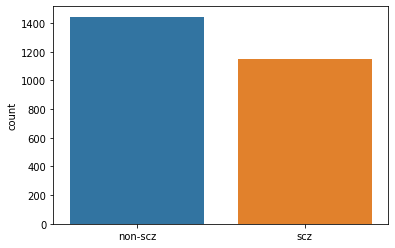

In [10]:
sns.countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


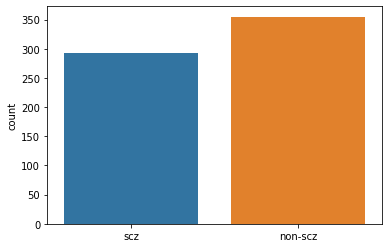

In [11]:
sns.countplot(y_test)

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
efficientnet = tf.keras.applications.EfficientNetB0(input_shape=(image_size,image_size,3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

16719872/16705208 [==============================] - 0s 0us/step


In [14]:
# This will let us use the default weights used by the imagenet.  
for layer in efficientnet.layers:
    layer.trainable = False
model = efficientnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(2,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnet.input, outputs = model)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [16]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [17]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("efficientnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [18]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.5772
Epoch 1: val_accuracy improved from -inf to 0.68077, saving model to efficientnet.h5
73/73 [==============================] - 25s 110ms/step - loss: 0.6999 - accuracy: 0.5772 - val_loss: 0.5785 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.5829 - accuracy: 0.7007
Epoch 2: val_accuracy improved from 0.68077 to 0.80769, saving model to efficientnet.h5
73/73 [==============================] - 6s 77ms/step - loss: 0.5829 - accuracy: 0.7007 - val_loss: 0.5171 - val_accuracy: 0.8077 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.7123
Epoch 3: val_accuracy did not improve from 0.80769
73/73 [==============================] - 5s 72ms/step - loss: 0.5440 - accuracy: 0.7123 - val_loss: 0.4865 - val_accuracy: 0.7885 - lr: 0.0010
Epoch 4/20
73/73 [==============================] - ETA: 0s - l

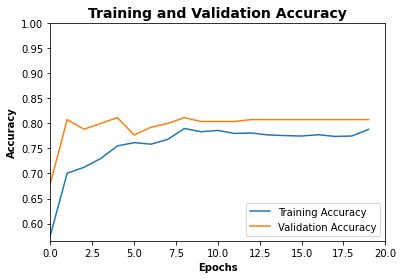

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy',fontweight='bold')
plt.xlim([0,20])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
# plt.legend(loc='best')
plt.savefig('EfficientNetTV1',dpi=400)
plt.show()

In [20]:
# train_score = model.evaluate_generator(train_dataset, steps=20, verbose=1)
# print("[INFO] accuracy: {:.2f}%".format(train_score[1] * 100)) 
# print("[INFO] Loss: ",train_score[0])
# print("[INFO] Precision: ",train_score[1])
# print("[INFO] Recall: ",train_score[1])

In [21]:
# test_score = model.evaluate_generator(test_dataset,steps=20, verbose=1)
# print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
# print("[INFO] Loss: ",test_score[0])
# print("[INFO] Precision: ",test_score[1])
# print("[INFO] Recall: ",test_score[1])

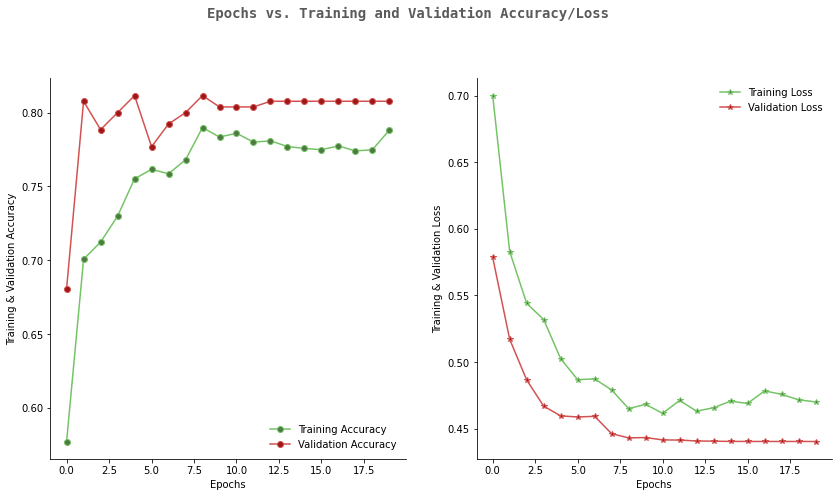

In [22]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=14,fontweight='bold',
             fontname='monospace',color='#313131',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='#4F7942',color='#74C365',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='#9E1717',color='#D35151',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training & Validation Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='*',markerfacecolor='#4F7942',color='#74C365',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='*',markerfacecolor='#9E1717',color='#D35151',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.savefig('EfficientNetTV2',dpi=400)
fig.show()

In [23]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [24]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       355
           1       0.89      0.73      0.80       293

    accuracy                           0.84       648
   macro avg       0.85      0.83      0.83       648
weighted avg       0.85      0.84      0.84       648



In [25]:
cm = confusion_matrix(y_test_new, pred)

Confusion matrix, without normalization


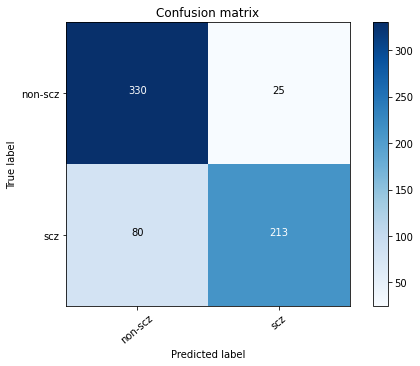

In [26]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,labels)
plt.savefig('EfficientNetCM',dpi=400)